In [1]:
import sys

sys.path.append("../")  # up one level

import os
import shutil

import gcsfs
import geopandas as gpd
import pandas as pd
from calitp_data_analysis.sql import to_snakecase
from calitp_data_analysis.tables import tbls
from segment_speed_utils.project_vars import PUBLIC_GCS
from siuba import _, collect, count, filter, select, show_query
from update_vars import GCS_FILE_PATH, NTD_MODES, NTD_TOS

GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/ntd/"

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# Work plan

## Need List of all annual reporters
- Full, Reduced, Rural reporters all submit an annual Report to NTD

## Need to assign rural and reduced annual reporters to RTPAs
- Full reporters are already mapped to RTPAs via the monthly report
- but reduced and rurap reporters need to be mapped to RTPAs

### How to traverse operators to RTPA?
- find all the operators in a GTFS schedule. 
- do any of the rural operators appear in a schedule?
    - if so, then what is the RTPA of that schedule!!!!!
    - ntd > operator > schedule > RTPA 

## Read in `dim_annual_service_agencies` to get metrics
but need to RTPA info to this data

In [2]:
# dim_annual_service_agenices is the annual report module.
# included uza, VRM, VRH, UPT
# report years include 2022-2023

ntd_service = (
    tbls.mart_ntd.dim_annual_service_agencies()
    >> filter(_.state == "CA")
    >> select(
        "report_year",
        "ntd_id",
        "agency",
        "reporter_type",
        "organization_type",
        "city",
        "state",
        "primary_uza_name",
        "actual_vehicles_passenger_car_revenue_hours",
        "actual_vehicles_passenger_car_revenue_miles",
        "unlinked_passenger_trips_upt",
    )
    >> collect()
)
ntd_service.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 11 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   report_year                                  421 non-null    int64  
 1   ntd_id                                       421 non-null    object 
 2   agency                                       421 non-null    object 
 3   reporter_type                                421 non-null    object 
 4   organization_type                            421 non-null    object 
 5   city                                         418 non-null    object 
 6   state                                        421 non-null    object 
 7   primary_uza_name                             328 non-null    object 
 8   actual_vehicles_passenger_car_revenue_hours  421 non-null    float64
 9   actual_vehicles_passenger_car_revenue_miles  421 non-null    float64
 10  un

### update `ntd_service` to:
- 90227 City of Moorpark > city = Moorpark
- 90253 City of Bell Gardens > city = Bell Gardens
- 90259 City of Cerritos > city = Cerritos
- 90286 City of Monterey Park > city = Monterey Park

In [3]:
display(
#Moorpark Update
    ntd_service.loc[ntd_service["ntd_id"]=="90227","city"],

# Bell Gardens Update
    ntd_service.loc[ntd_service["ntd_id"]=="90253","city"],

# Cerritos Update
    ntd_service.loc[ntd_service["ntd_id"]=="90259","city"],

# Monterey Park Update
    ntd_service.loc[ntd_service["ntd_id"]=="90286","city"]
    
)

294        None
295    Moorpark
Name: city, dtype: object

314    Bell
315    None
Name: city, dtype: object

326        None
327    Cerritos
Name: city, dtype: object

376    Montery Park
377    Montery Park
Name: city, dtype: object

In [4]:
#Moorpark Update
ntd_service.loc[ntd_service["ntd_id"]=="90227","city"] = "Moorpark"

# Bell Gardens Update
ntd_service.loc[ntd_service["ntd_id"]=="90253","city"] = "Bell Gardens"

# Cerritos Update
ntd_service.loc[ntd_service["ntd_id"]=="90259","city"] = "Cerritos"

# Monterey Park Update
ntd_service.loc[ntd_service["ntd_id"]=="90286","city"] = "Monterey Park"

In [5]:
display(
#Moorpark Update
    ntd_service.loc[ntd_service["ntd_id"]=="90227","city"],

# Bell Gardens Update
    ntd_service.loc[ntd_service["ntd_id"]=="90253","city"],

# Cerritos Update
    ntd_service.loc[ntd_service["ntd_id"]=="90259","city"],

# Monterey Park Update
    ntd_service.loc[ntd_service["ntd_id"]=="90286","city"]
    
)

294    Moorpark
295    Moorpark
Name: city, dtype: object

314    Bell Gardens
315    Bell Gardens
Name: city, dtype: object

326    Cerritos
327    Cerritos
Name: city, dtype: object

376    Monterey Park
377    Monterey Park
Name: city, dtype: object

### Does `ntd_id-to-rtap crosswalk` include rural/reduced reporter info?

In [6]:
# reading in NTD ID crosswalk from GCS
ntd_rtpa_crosswalk = pd.read_csv(
    f"{GCS_FILE_PATH}ntd_id_rtpa_crosswalk.csv", dtype={"ntd_id": "str"}
).rename(columns={"NTD ID": "ntd_id"})

ntd_rtpa_crosswalk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ntd_id          122 non-null    object
 1   Legacy NTD ID   111 non-null    object
 2   Agency          122 non-null    object
 3   UZA Name        121 non-null    object
 4   RTPA_open_data  122 non-null    object
 5   RTPA            122 non-null    object
dtypes: object(6)
memory usage: 5.8+ KB


In [7]:
# are all agencies in the ntd_service in the crosswalk? NO
check = ntd_service.merge(ntd_rtpa_crosswalk, on="ntd_id", how="left", indicator=True)

# the rural reporters are not in the ntd_rtpa_crosswalk
check[check["_merge"] == "left_only"]["reporter_type"].value_counts()

Reduced Reporter    132
Rural Reporter       89
Name: reporter_type, dtype: int64

In [8]:
# crosswalk[["UZA Name", "RTPA"]].sort_values(by="UZA Name")

Some UZA Names can go to multiple RTPAs
- some agencies in the Sacramento UZA go to Sac and Placer RTPA
- some agencies in LA UZA got to Metro or OCTA


In [9]:
# just rural/reduced reporters
rural_reduced_reporters = ntd_service[
    ntd_service["reporter_type"] != "Full Reporter"
].sort_values(by="primary_uza_name")

In [10]:
# rural_reduced_reporters.to_csv("rural_reduced_reporters.csv")

## Get all operators from RTPA using function from Tiffany

via [slack thread](https://cal-itp.slack.com/archives/C02H6JUSS9L/p1729102048291249)

initial work done in `rtpa_operator_explore.ipynb`

- rip `create_gtfs_dataset_key_to_organization_crosswalk` function from `gtfs_funnel/crosswalk_gtfs_dataset_key_to_organization.py`
- rip any date from GCS (latest is 2025-01-15) `calitp-analytics-data/data-analyses/gtfs_schedule/crosswalk`
- find the corresponding `gtfs_key-to-org crosswalk` by date (2025-01-15) via `calitp-analytics-data/data-analyses/gtfs_schedule/crosswalk`

can use these 2 dataframes to go from `schedule_gtfs_dataset_key (operator)` > `ntd_id`

A single schedule feed can have multiple operators. This is how you identify 

In [11]:
# need this to run `create_gtfs_dataset_key_to_organzaition_crosswalk`
from segment_speed_utils import helpers
from shared_utils.schedule_rt_utils import (
    sample_gtfs_dataset_key_to_organization_crosswalk,
)

In [12]:
def create_gtfs_dataset_key_to_organization_crosswalk(
    analysis_date: str,
) -> pd.DataFrame:
    """
    For every operator that appears in schedule data,
    create a crosswalk that links to organization_source_record_id.
    For all our downstream outputs, at various aggregations,
    we need to attach these over and over again.
    """
    df = helpers.import_scheduled_trips(
        analysis_date, columns=["gtfs_dataset_key", "name"], get_pandas=True
    ).rename(columns={"schedule_gtfs_dataset_key": "gtfs_dataset_key"})
    # rename columns because we must use simply gtfs_dataset_key in schedule_rt_utils function

    # Get base64_url, organization_source_record_id and organization_name
    crosswalk = sample_gtfs_dataset_key_to_organization_crosswalk(
        df,
        analysis_date,
        quartet_data="schedule",
        dim_gtfs_dataset_cols=["key", "source_record_id", "base64_url"],
        dim_organization_cols=[
            "source_record_id",
            "name",
            "itp_id",
            "caltrans_district",
            "ntd_id_2022",
        ],
    )

    df_with_org = pd.merge(
        df.rename(columns={"gtfs_dataset_key": "schedule_gtfs_dataset_key"}),
        crosswalk,
        on="schedule_gtfs_dataset_key",
        how="inner",
    )

    return df_with_org

In [13]:
# get gtfs to org df,
# same date as used below
gtfs_to_org = create_gtfs_dataset_key_to_organization_crosswalk(
    "2025-01-15"  # 216 total rows
    # "2024-10-14" #209 rows
    # "2024-08-14" #206 rows
    # "2024-03-13" #193 rows
).rename(columns={"name": "schedule_name"})


gtfs_to_org.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216 entries, 0 to 215
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   schedule_gtfs_dataset_key      216 non-null    object 
 1   schedule_name                  216 non-null    object 
 2   schedule_source_record_id      216 non-null    object 
 3   base64_url                     216 non-null    object 
 4   organization_source_record_id  216 non-null    object 
 5   organization_name              216 non-null    object 
 6   itp_id                         204 non-null    float64
 7   caltrans_district_x            214 non-null    object 
 8   ntd_id_2022                    172 non-null    object 
 9   caltrans_district_y            216 non-null    object 
dtypes: float64(1), object(9)
memory usage: 18.6+ KB


In [14]:
# initialize gtfs rosswalk
gtfs_key_orgs = pd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/gtfs_schedule/crosswalk/gtfs_key_organization_2025-01-15.parquet"
)
gtfs_key_orgs.columns # not sure i cant use these columns

Index(['schedule_gtfs_dataset_key', 'name', 'schedule_source_record_id',
       'base64_url', 'organization_source_record_id', 'organization_name',
       'caltrans_district', 'counties_served', 'hq_city', 'hq_county',
       'is_public_entity', 'is_publicly_operating', 'funding_sources',
       'on_demand_vehicles_at_max_service', 'vehicles_at_max_service',
       'number_of_state_counties', 'primary_uza_name', 'density',
       'number_of_counties_with_service', 'state_admin_funds_expended',
       'service_area_sq_miles', 'population', 'service_area_pop',
       'subrecipient_type', 'primary_uza_code', 'reporter_type',
       'organization_type', 'voms_pt', 'voms_do', 'year'],
      dtype='object')

## Merge `ntd_service` data to `gtfs_to_orgs` list
Results should be the ntd_service data with the GTFS schedule name 

In [15]:
keep_cols = [
    "schedule_gtfs_dataset_key",
    "schedule_name",
    "organization_name",
    "ntd_id_2022",
]

ntd_metrics_to_sched = ntd_service.merge(
    gtfs_to_org[keep_cols],
    right_on="ntd_id_2022",
    left_on="ntd_id",
    how="left",
    indicator=True,
)
display(ntd_metrics_to_sched.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455 entries, 0 to 454
Data columns (total 16 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   report_year                                  455 non-null    int64   
 1   ntd_id                                       455 non-null    object  
 2   agency                                       455 non-null    object  
 3   reporter_type                                455 non-null    object  
 4   organization_type                            455 non-null    object  
 5   city                                         455 non-null    object  
 6   state                                        455 non-null    object  
 7   primary_uza_name                             356 non-null    object  
 8   actual_vehicles_passenger_car_revenue_hours  455 non-null    float64 
 9   actual_vehicles_passenger_car_revenue_miles  455 non-null    floa

None

In [16]:
ntd_metrics_to_sched["_merge"].value_counts()
# so there are some left-only rows, meaning some operators did not match to schedule
# on date 2025-01-15: 257 both, 88 left_only = 88 reporters did not match to a shcedule

both          326
left_only     129
right_only      0
Name: _merge, dtype: int64

In [17]:
# what are the reporter types for these left_only operators?
ntd_metrics_to_sched[ntd_metrics_to_sched["_merge"] == "left_only"][
    "reporter_type"
].value_counts()  # 65 reduced, 23 full reporters

# also checked "both" and got mix of full, reduced and rural
# may need to check a different crosswalk data

Reduced Reporter    74
Rural Reporter      32
Full Reporter       23
Name: reporter_type, dtype: int64

In [18]:
# looking into the cities of the left_only merges
ntd_metrics_to_sched[ntd_metrics_to_sched["_merge"] == "left_only"][
    ["agency", "reporter_type", "city"]
].value_counts()

agency                                                                          reporter_type     city            
Los Angeles County                                                              Reduced Reporter  Alhambra            9
Access Services                                                                 Full Reporter     El Monte            2
City of Malibu                                                                  Reduced Reporter  Malibu              2
Paratransit, Inc.                                                               Full Reporter     Sacramento          2
City of Covina                                                                  Reduced Reporter  Covina              2
City of Davis, dba: Davis Community Transit                                     Reduced Reporter  Davis               2
Easy Lift Transportation                                                        Reduced Reporter  Goleta              2
City of Huntington Park                      

In [19]:
# if i sort by city, can i match copy the RTPA of the good rows to the left_only rows?
ntd_metrics_to_sched[
    ["agency", "city", "schedule_gtfs_dataset_key", "schedule_name", "_merge"]
].sort_values(by=["city", "agency"], ascending=True).head(10)

,agency,city,schedule_gtfs_dataset_key,schedule_name,_merge
334,City of Agoura Hills,Agoura Hills,NaN,NaN,left_only
335,City of Agoura Hills,Agoura Hills,NaN,NaN,left_only
337,"City of Alhambra, dba: Alhambra Community Transit",Alhambra,9471fbb88956076b211cc4a8df1a536c,Alhambra Schedule,both
336,"City of Alhambra, dba: Alhambra Community Tran...",Alhambra,9471fbb88956076b211cc4a8df1a536c,Alhambra Schedule,both
381,Los Angeles County,Alhambra,NaN,NaN,left_only
383,Los Angeles County,Alhambra,2606479845d2cf0077fac54ff25a3a69,LADPW Schedule,both
384,Los Angeles County,Alhambra,NaN,NaN,left_only
387,Los Angeles County,Alhambra,NaN,NaN,left_only
388,Los Angeles County,Alhambra,NaN,NaN,left_only
391,Los Angeles County,Alhambra,NaN,NaN,left_only


## merge `ntd_metrics_to_sched` df to `ntd_to_rtpa` crosswalk
Result should be a df of ntd service reports with GTFS schedule, then RTPA name merged in

In [20]:
metrics_sched_rtpa = ntd_metrics_to_sched.drop(columns="_merge", axis=1).merge(
    ntd_rtpa_crosswalk, on="ntd_id", how="left", indicator=True
)

metrics_sched_rtpa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 457 entries, 0 to 456
Data columns (total 21 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   report_year                                  457 non-null    int64   
 1   ntd_id                                       457 non-null    object  
 2   agency                                       457 non-null    object  
 3   reporter_type                                457 non-null    object  
 4   organization_type                            457 non-null    object  
 5   city                                         457 non-null    object  
 6   state                                        457 non-null    object  
 7   primary_uza_name                             358 non-null    object  
 8   actual_vehicles_passenger_car_revenue_hours  457 non-null    float64 
 9   actual_vehicles_passenger_car_revenue_miles  457 non-null    floa

In [21]:
metrics_sched_rtpa["_merge"].value_counts()
# on date 2025-01-15: 227 both, 120 left_only = 120 reporters did not match to a RTPA
# ideally want every row to match

left_only     229
both          228
right_only      0
Name: _merge, dtype: int64

In [22]:
# get DF of agencies > reporter type > city > schedule name > rtpa
# if 2 reporters share the same City, then are they part of the same schedule? or part of the same RTPA?

metrics_sched_rtpa[
    [
        "report_year",
        "ntd_id",
        "agency",
        "reporter_type",
        "city",
        "schedule_name",
        "RTPA",
    ]
].sort_values(by=["city", "RTPA"], ascending=True)

# examples to pull: Camarillo, Riverside, 

,report_year,ntd_id,agency,reporter_type,city,schedule_name,RTPA
336,2023,90246,City of Agoura Hills,Reduced Reporter,Agoura Hills,NaN,NaN
337,2022,90246,City of Agoura Hills,Reduced Reporter,Agoura Hills,NaN,NaN
338,2022,90247,"City of Alhambra, dba: Alhambra Community Tran...",Reduced Reporter,Alhambra,Alhambra Schedule,NaN
339,2023,90247,"City of Alhambra, dba: Alhambra Community Transit",Reduced Reporter,Alhambra,Alhambra Schedule,NaN
380,2022,90269,Los Angeles County Dept. of Public Works - Ath...,Reduced Reporter,Alhambra,NaN,NaN
381,2023,90269,"Los Angeles County, dba: LA County Public Works",Reduced Reporter,Alhambra,NaN,NaN
382,2022,90270,Los Angeles County Department of Public Works ...,Reduced Reporter,Alhambra,NaN,NaN
383,2023,90270,Los Angeles County,Reduced Reporter,Alhambra,NaN,NaN
384,2022,90271,Los Angeles County Department of Public Works ...,Reduced Reporter,Alhambra,LADPW Schedule,NaN
385,2023,90271,Los Angeles County,Reduced Reporter,Alhambra,LADPW Schedule,NaN


## try merging GDF of city in dim_services to RTPA bounaries.
- To match agency cities to RTPAs. (this method doesnt need schedule info)

California Incorporated Cities (dont think this included census derived places or unincorporated areas.)
- https://gis.data.cnra.ca.gov/datasets/CALFIRE-Forestry::california-incorporated-cities-1/explore

RTPA opend ata
- https://www.lab.data.ca.gov/dataset/regional-transportation-planning-agencies

In [23]:
import geopandas as gpd

In [80]:
rtpa_url = "https://cecgis-caenergy.opendata.arcgis.com/api/download/v1/items/3a83743378be4e7f84c8230889c01dea/geojson?layers=0"
rtpa_map = gpd.read_file(rtpa_url)[["RTPA","LABEL_RTPA","geometry"]]#.set_crs("ESRI:102600", allow_override=True)


# California Incorporated Cities!!!!! dont think this included census derived places or unincorporated areas.
cities_url="https://gis.data.cnra.ca.gov/api/download/v1/items/8322505e8f1741c7b0de85684594e32a/geojson?layers=0"
cities_map =gpd.read_file(cities_url)[["COUNTY","CITY","geometry"]]#.set_crs("ESRI:102600", allow_override=True)

In [81]:
display(
    rtpa_map.info(),
    rtpa_map.crs,
    rtpa_map.head()
)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   RTPA        43 non-null     object  
 1   LABEL_RTPA  43 non-null     object  
 2   geometry    43 non-null     geometry
dtypes: geometry(1), object(2)
memory usage: 1.1+ KB


None

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

,RTPA,LABEL_RTPA,geometry
0,Alpine County Local Transportation Commission,Alpine LTC,"POLYGON ((-119.58544 38.71321, -119.58493 38.7..."
1,Amador County Transportation Commission,Amador CTC,"POLYGON ((-120.07239 38.70277, -120.07239 38.7..."
2,Butte County Association of Governments,BCAG,"POLYGON ((-121.07669 39.59726, -121.07954 39.5..."
3,Calaveras Council of Governments,Calaveras COG,"POLYGON ((-120.01995 38.43352, -120.02020 38.4..."
4,Colusa County Transportation Commission,Colusa CTC,"POLYGON ((-121.89001 39.38386, -121.88995 39.3..."


In [82]:
display(
    cities_map.info(),
    cities_map.crs,
    cities_map.head()
)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 482 entries, 0 to 481
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   COUNTY    482 non-null    object  
 1   CITY      482 non-null    object  
 2   geometry  482 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 11.4+ KB


None

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

,COUNTY,CITY,geometry
0,San Bernardino County,Adelanto,"MULTIPOLYGON (((-117.39179 34.62318, -117.3917..."
1,Los Angeles County,Agoura Hills,"MULTIPOLYGON (((-118.71983 34.13629, -118.7198..."
2,Alameda County,Alameda,"MULTIPOLYGON (((-122.33016 37.79712, -122.3293..."
3,Alameda County,Albany,"MULTIPOLYGON (((-122.28810 37.89800, -122.2877..."
4,Los Angeles County,Alhambra,"MULTIPOLYGON (((-118.12207 34.10517, -118.1219..."


## sjoin `cities_map` gdf and `rtpa_map` gdf to attach RTPA name to cities

In [83]:
city_to_rtpa = gpd.sjoin(
    cities_map,
    rtpa_map,
    how="inner",
    predicate="intersects"
)

display(
    city_to_rtpa.info(),
    city_to_rtpa.crs,

)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 509 entries, 0 to 424
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   COUNTY       509 non-null    object  
 1   CITY         509 non-null    object  
 2   geometry     509 non-null    geometry
 3   index_right  509 non-null    int64   
 4   RTPA         509 non-null    object  
 5   LABEL_RTPA   509 non-null    object  
dtypes: geometry(1), int64(1), object(4)
memory usage: 27.8+ KB


None

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [84]:
city_to_rtpa.head()

,COUNTY,CITY,geometry,index_right,RTPA,LABEL_RTPA
0,San Bernardino County,Adelanto,"MULTIPOLYGON (((-117.39179 34.62318, -117.3917...",35,Southern California Association of Governments,SCAG
1,Los Angeles County,Agoura Hills,"MULTIPOLYGON (((-118.71983 34.13629, -118.7198...",35,Southern California Association of Governments,SCAG
4,Los Angeles County,Alhambra,"MULTIPOLYGON (((-118.12207 34.10517, -118.1219...",35,Southern California Association of Governments,SCAG
5,Orange County,Aliso Viejo,"MULTIPOLYGON (((-117.71644 33.59766, -117.7165...",35,Southern California Association of Governments,SCAG
9,Orange County,Anaheim,"MULTIPOLYGON (((-117.74880 33.87446, -117.7484...",35,Southern California Association of Governments,SCAG


<AxesSubplot:>

43

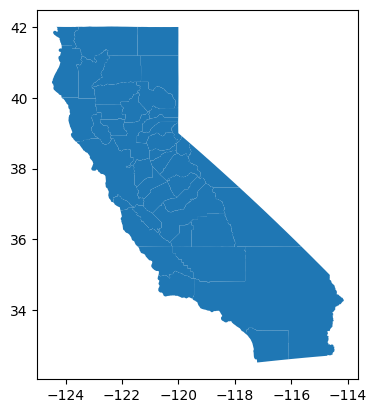

In [61]:
display(
    rtpa_map.plot(),
    len(rtpa_map)
)

<AxesSubplot:>

482

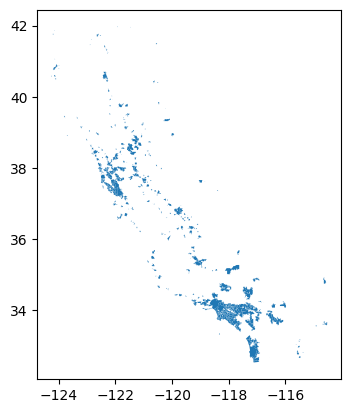

In [67]:
display(
    cities_map.plot(),
    cities_map["CITY"].nunique()
)

<AxesSubplot:>

481

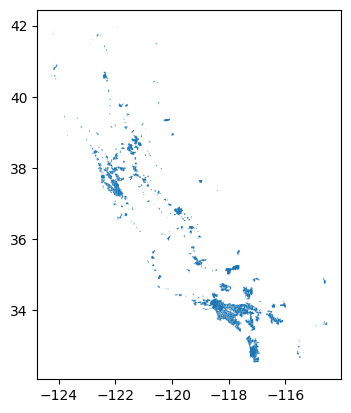

In [68]:
display(
    city_to_rtpa.plot(),## results
    city_to_rtpa["CITY"].nunique()
)

## merge `ntd_service` to `city_to_rtpa`
join on City. attach RTPA name to ntd annual data

In [32]:
display(
    ntd_service.info(),
    city_to_rtpa.columns
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 11 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   report_year                                  421 non-null    int64  
 1   ntd_id                                       421 non-null    object 
 2   agency                                       421 non-null    object 
 3   reporter_type                                421 non-null    object 
 4   organization_type                            421 non-null    object 
 5   city                                         421 non-null    object 
 6   state                                        421 non-null    object 
 7   primary_uza_name                             328 non-null    object 
 8   actual_vehicles_passenger_car_revenue_hours  421 non-null    float64
 9   actual_vehicles_passenger_car_revenue_miles  421 non-null    float64
 10  un

None

Index(['OBJECTID_left', 'COUNTY', 'CITY', 'SHAPE_Length', 'SHAPE_Area',
       'geometry', 'index_right', 'OBJECTID_1', 'OBJECTID_right', 'RTPA',
       'LABEL_RTPA', 'SHAPE_Leng', 'Shape__Area', 'Shape__Length'],
      dtype='object')

In [52]:
ntd_data_to_rtpa = ntd_service.merge(
    city_to_rtpa[["CITY","COUNTY","RTPA","LABEL_RTPA"]],
    left_on=("city"),
    right_on=("CITY"),
    how="inner", # with left join, got some unmerged rows. aka agencies that dont reside in an RTPA
    indicator=True
)
ntd_data_to_rtpa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 413 entries, 0 to 412
Data columns (total 16 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   report_year                                  413 non-null    int64   
 1   ntd_id                                       413 non-null    object  
 2   agency                                       413 non-null    object  
 3   reporter_type                                413 non-null    object  
 4   organization_type                            413 non-null    object  
 5   city                                         413 non-null    object  
 6   state                                        413 non-null    object  
 7   primary_uza_name                             332 non-null    object  
 8   actual_vehicles_passenger_car_revenue_hours  413 non-null    float64 
 9   actual_vehicles_passenger_car_revenue_miles  413 non-null    floa

In [54]:
ntd_data_to_rtpa["_merge"].value_counts() # 12 left_only rows, who are there?



both          413
left_only       0
right_only      0
Name: _merge, dtype: int64



then Update `ntd_data_to_rtpa` with the following information:
- 90079 SunLine Transit > COUNTY = Riverside County. RTPA = Southern California Association of Governments
- 90229 El Dorado County Transit Authority > COUNTY = El Dorado County. RTPA =  El Dorado County Transportation Commission
- 90287 Palos Verdes Peninsula Transit Authority > COUNTY = Los Angeles County. RTPA = Southern California Association of Governments
- 91092 Tahoe Transportation District > COUNTY El Dorado County. RTPA = Tahoe Regional Planning Agency

In [45]:
list(ntd_data_to_rtpa[ntd_data_to_rtpa["_merge"]=="left_only"]["city"].unique())
# most of these are CDP or subrgion, 

# Thousand Palms, update RTPA to 

['Thousand Palms',
 'Weaverville',
 'Downieville',
 'Lower Lake',
 'Mariposa',
 'Gerber',
 'Joshua Tree',
 'Mcfarland',
 'California City',
 'Markleeville',
 'Quincy',
 'San Andreas',
 'Diamond Springs',
 'Avalon',
 'Palos Verdes Peninsula',
 'Klamath',
 'Havasu Lake',
 'North Fork']

In [49]:
# checking CDP names in cities lsit
city_check_list = list(ntd_data_to_rtpa[ntd_data_to_rtpa["_merge"]=="left_only"]["city"].unique())

city_check_list_2 =[
    "Thousand Palms"
    "Diamond Springs"
    "Palos Verdes Peninsula"
]

county_check_list = [
    #"Riverside County",
    "El Dorado County",
    #"Los Angeles County"
]

display(
    city_to_rtpa[city_to_rtpa["CITY"].isin(city_check_list)],#["RTPA"].unique() # CPD are not here.,
    cities_map[cities_map["CITY"].isin(city_check_list)]
)

# googl'ing the counties in for these CDPs
# thousand palms = Riverside County = Southern California Association of Governments
# diamond spring = El Dorado County = El Dorado County Transportation Commission (closer to placerville than Tahoe)
# Palos Verdes Penisula = LA County... sooo Southern California Association of Governments

,OBJECTID_left,COUNTY,CITY,SHAPE_Length,SHAPE_Area,geometry,index_right,OBJECTID_1,OBJECTID_right,RTPA,LABEL_RTPA,SHAPE_Leng,Shape__Area,Shape__Length


,OBJECTID,COUNTY,CITY,SHAPE_Length,SHAPE_Area,geometry
23,24,Los Angeles County,Avalon,0.166773,0.000722,"MULTIPOLYGON (((-118.33156 33.35623, -118.3312..."
